In [12]:
import os, glob
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
import scipy.sparse as sp

import pandas as pd
pd.options.display.float_format = "{:.3e}".format
pd.set_option("display.max_columns", None)
pd.set_option("display.width", 2000)
pd.set_option("display.max_colwidth", 120)
pd.set_option("display.expand_frame_repr", False)

import sys
from pathlib import Path
PROJECT_ROOT = Path().resolve().parents[1]  # notebooks/ → cone-operator-lab/
sys.path.insert(0, str(PROJECT_ROOT))

from modules.weyl_fit import volume_quality_from_eigs, vol_from_first_m, true_ellipsoid_volume

In [13]:
def load_eigs_txt(path):
    arr = np.loadtxt(path, dtype=float)
    arr = np.asarray(arr).reshape(-1)
    arr = arr[np.isfinite(arr)]
    arr.sort()
    return arr

In [14]:
a_true, b_true, c_true = 1.0, 1.5, 2.3
V_true = true_ellipsoid_volume(a_true, b_true, c_true)

frac_range = (0.2, 0.9)
alpha = 1e-6

In [15]:
pattern = r"C:\Users\sulta\git\cone-operator-lab\data\eigenvalues\*.txt"
files = sorted(glob.glob(pattern))
if len(files) < 1:
    raise RuntimeError("No .txt files found.")

rows = []
for f in files:
    eigs = load_eigs_txt(f)

    V_spec, V_true, rel_vol_err, (A0, A1, A2) = volume_quality_from_eigs(
        eigs,
        a=a_true, b=b_true, c=c_true,
        frac_range=frac_range,
        alpha=alpha
    )

    rows.append({
        "file": os.path.basename(f),
        "N_eigs": int(eigs.size),
        "V_spec": V_spec,
        "V_true": V_true,
        "rel_vol_err": rel_vol_err,
        "A0": A0,
        "A1": A1,
        "A2": A2
    })

df = pd.DataFrame(rows)
# beste Volumenqualität oben
df = df.sort_values("rel_vol_err").reset_index(drop=True)
display(df[["file","N_eigs","rel_vol_err","V_spec","V_true"]])

,file,N_eigs,rel_vol_err,V_spec,V_true
0,ellipsoid_eigs_a1_b1.5_c2.3_arnoldi-1000.txt,1000,3.838e-02,1.390e+01,1.445e+01
1,ellipsoid_a1.0_b1.5_c2.3_N400.txt,400,5.396e-02,1.367e+01,1.445e+01
2,ellipsoid_eigs_a1_b1.5_c2.3_arnoldi-1800.txt,1800,1.090e-01,1.288e+01,1.445e+01
3,ellipsoid_a1.0_b1.5_c2.3_N1000.txt,1000,3.993e-01,8.681e+00,1.445e+01


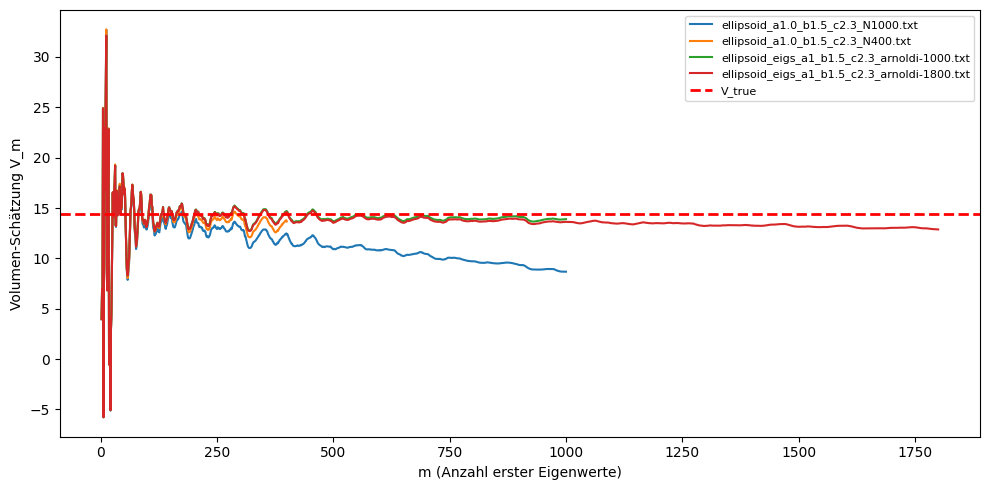

In [17]:
plt.figure(figsize=(10, 5))

for f in files:
    eigs_all = load_eigs_txt(f)
    num_eigs = eigs_all.size
    maxN = num_eigs
    vol_conv_data = np.array(
        [(m, vol_from_first_m(eigs_all[:m], frac_range, alpha)) for m in range(2, maxN + 1)],
        dtype=float
    )

    plt.plot(vol_conv_data[:, 0], vol_conv_data[:, 1], label=os.path.basename(f))

plt.axhline(V_true, color="red", linestyle="--", linewidth=2, label="V_true")
plt.xlabel("m (Anzahl erster Eigenwerte)")
plt.ylabel("Volumen-Schätzung V_m")
plt.legend(fontsize=8)
plt.tight_layout()
plt.show()